## What is mRMR (Maximum Relevance Minimum Redundancy)?

**mRMR (Maximum Relevance Minimum Redundancy)** is a **filter-based feature selection framework** that aims to select features that are:

1. **Highly relevant** to the target variable
2. **Minimally redundant** with respect to each other

Instead of selecting features solely based on their individual importance, mRMR balances **usefulness** and **diversity**.

---

## Core Idea

At each step, select the feature that:

- Maximizes its **relevance** to the target
- Minimizes its **redundancy** with already selected features

This produces a compact and informative feature subset.

---

## Relevance

Relevance measures how informative a feature is about the target variable.

Common measures:

- Mutual Information:  
  $ I(X_j; Y) $
- Correlation (for regression)
- F-score / ANOVA (classification)

---

## Redundancy

Redundancy measures how similar a candidate feature is to the features already selected.

Common measures:

- Mutual Information between features:  
  $ I(X_j; X_k) $
- Pearson or Spearman correlation

---

## mRMR Objective

For a candidate feature $X_j$ and selected feature set $S$:

$$
\mathrm{mRMR}(X_j)
=
I(X_j; Y)
-
\frac{1}{|S|}
\sum_{X_k \in S}
I(X_j; X_k)
$$

### Interpretation

- The first term rewards features that are **highly informative about the target**.
- The second term penalizes features that are **redundant with already selected features**.
- The balance ensures selected features are **both useful and diverse**.


---
## Why mRMR Is Especially Useful for Signal (Sensor) Data

At first glance, features extracted from signal or sensor data are **just numerical values**, similar to any other tabular dataset. However, what makes signal data **special** is **how these numbers are generated**, not the fact that they are numeric.

> **mRMR is particularly effective for signal data because signal features are highly redundant by construction.**
---

## Signal Features Are Derived from the Same Source

Signal-processing pipelines typically follow this structure:

Raw signal → Windowing → Time-domain statistics → Frequency-domain features → Wavelet / spectral transforms

From a **single physical signal**, we often extract:

- Mean, variance, RMS
- Skewness, kurtosis
- FFT band powers
- Overlapping window statistics

As a result, many features originate from the **same underlying signal**, making them strongly dependent.

---

## Redundancy in Signal Data Is Structural, Not Accidental

In generic tabular datasets:

- Correlations often arise accidentally
- Features may represent unrelated concepts

In signal data:

- Redundancy is enforced by **physics and signal processing**
- Adjacent sensors measure similar phenomena
- Overlapping time windows share information
- Neighboring frequency bands overlap spectrally

Examples:

- RMS(0–1s) vs RMS(0.5–1.5s)
- Power(10–12Hz) vs Power(11–13Hz)

These features are **mathematically redundant**, not just statistically correlated.

---

- Embedded models optimize prediction, not diversity

- If multiple correlated features help prediction, the model may keep all of them

- There is no built-in penalty for selecting similar features


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from feature_engine.selection import MRMR

In [2]:
X = pd.DataFrame(load_breast_cancer().data, columns=load_breast_cancer().feature_names)
y = pd.Series(load_breast_cancer().target)

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

In [4]:
# Initialize the mRMR selector with the "FCQ" (F-test Correlation Quotient) method
# to select up to 10 features for a classification problem, then fit it to the data
# X and target y.

selector = MRMR(method="FCQ", max_features=10, regression=False)

selector.fit(X_train, y_train)

,variables,None
,method,'FCQ'
,max_features,10
,discrete_features,'auto'
,n_neighbors,3
,scoring,'roc_auc'
,cv,3
,param_grid,None
,regression,False
,confirm_variables,False
,random_state,None


In [5]:
selector.relevance_

array([4.09324586e+02, 7.82141420e+01, 4.43061554e+02, 3.56084616e+02,
       5.79040462e+01, 2.03275859e+02, 3.62653784e+02, 6.16646516e+02,
       5.56815629e+01, 4.07997082e-01, 1.67442537e+02, 1.81306268e-01,
       1.53884377e+02, 1.40741452e+02, 9.63553272e-01, 3.15442870e+01,
       2.63234598e+01, 7.30964306e+01, 4.41799917e-01, 1.43610839e+00,
       5.47254347e+02, 1.03689584e+02, 5.80041174e+02, 4.14736757e+02,
       7.81540764e+01, 2.02403065e+02, 3.30705030e+02, 6.62320337e+02,
       9.17932292e+01, 3.65031400e+01])

In [6]:
selector.get_feature_names_out()

['mean radius',
 'mean perimeter',
 'mean area',
 'mean concavity',
 'mean concave points',
 'worst radius',
 'worst perimeter',
 'worst area',
 'worst concavity',
 'worst concave points']

In [7]:
relevance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Relevance Score': selector.relevance_
}).sort_values(by='Relevance Score', ascending=False)

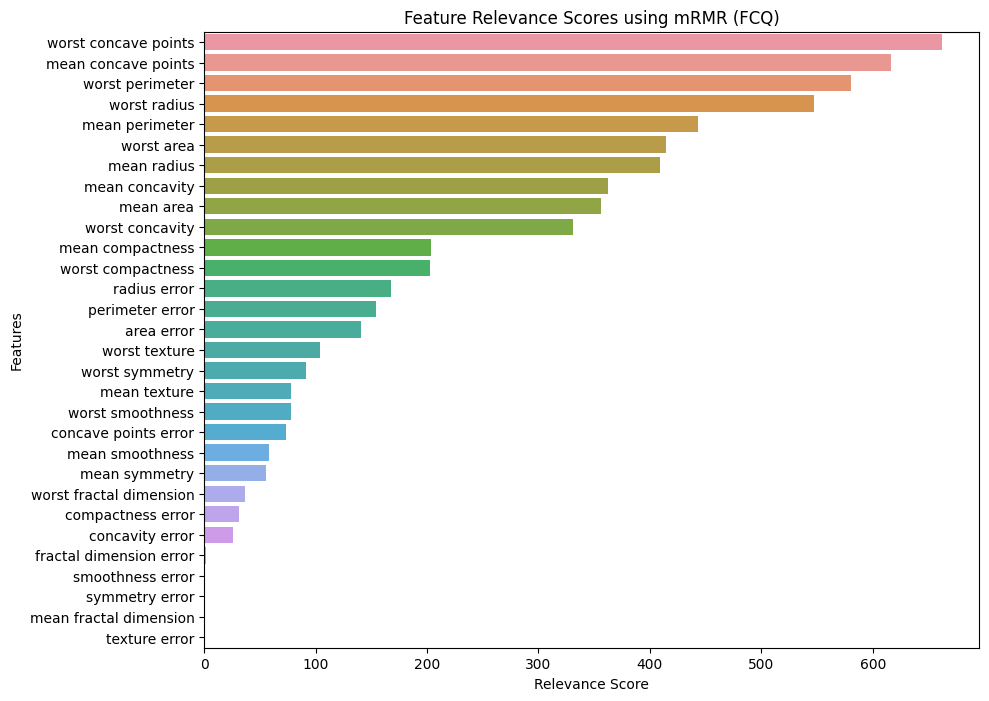

In [8]:
plt.figure(figsize=(10, 8))
sns.barplot(
    data=relevance_df,
    x="Relevance Score",
    y="Feature",
)
plt.title("Feature Relevance Scores using mRMR (FCQ)")
plt.xlabel("Relevance Score")
plt.ylabel("Features")
plt.show()

In [9]:
selector.features_to_drop_

['mean texture',
 'mean smoothness',
 'mean compactness',
 'mean symmetry',
 'mean fractal dimension',
 'radius error',
 'texture error',
 'perimeter error',
 'area error',
 'smoothness error',
 'compactness error',
 'concavity error',
 'concave points error',
 'symmetry error',
 'fractal dimension error',
 'worst texture',
 'worst smoothness',
 'worst compactness',
 'worst symmetry',
 'worst fractal dimension']

## Using Other Methods

The MRMR selector can use different algorithms/methods for feature selection.
Common options include:

- `FCQ` : F-test Correlation Quotient (classification)
- `FCD` : F-test Correlation Difference (classification)
- `MIQ` : Mutual Information Quotient (classification or regression)
- `MID` : Mutual Information Difference (classification or regression)
- `RFCQ`: Random Forest Correlation Quotient (uses tree-based feature importance)
- `RFD` : Random Forest Correlation Difference


In [10]:
selector = MRMR(
    method="RFCQ",
    scoring="roc_auc",
    param_grid = {
        'n_estimators': [50, 100],
        'max_depth': [3, 5, None],
    },
    max_features=8,
    cv=3,
    regression=False,
    random_state=42,
)

selector.fit(X_train, y_train)

,variables,None
,method,'RFCQ'
,max_features,8
,discrete_features,'auto'
,n_neighbors,3
,scoring,'roc_auc'
,cv,3
,param_grid,"{'max_depth': [3, 5, ...], 'n_estimators': [50, 100]}"
,regression,False
,confirm_variables,False
,random_state,42


In [11]:
selector.get_feature_names_out()

['mean concavity',
 'mean concave points',
 'symmetry error',
 'worst radius',
 'worst perimeter',
 'worst area',
 'worst concavity',
 'worst concave points']